In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import os
import pandas as pd 
from keras.models import Model
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import RMSprop,Adam

Loading data

In [2]:
training_images = []
training_groundTruth = []
validation_images = []
validation_groundTruth = []
test_images = []
test_groundTruth = []

path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/train/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  training_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/train/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  training_groundTruth.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/valid/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  validation_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/valid/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  validation_groundTruth.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/test/images/images"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  test_images.append(img)
    
path = "../input/isic2017-256x256-jpeg/ISIC_2017_256x256/test/masks/masks"
paths = os.listdir(path)
paths.sort()
for image in paths:
  img = cv2.imread(path + '/' + image)
  test_groundTruth.append(img)

In [3]:
training_images = np.array(training_images)
training_groundTruth = np.array(training_groundTruth)
validation_images = np.array(validation_images)
validation_groundTruth = np.array(validation_groundTruth)
test_images = np.array(test_images)
test_groundTruth = np.array(test_groundTruth)
training_images.sort()
training_groundTruth.sort()
input_shape = training_images[0].shape
print(input_shape)
print(training_groundTruth.shape)

(256, 256, 3)
(2000, 256, 256, 3)


Image samples

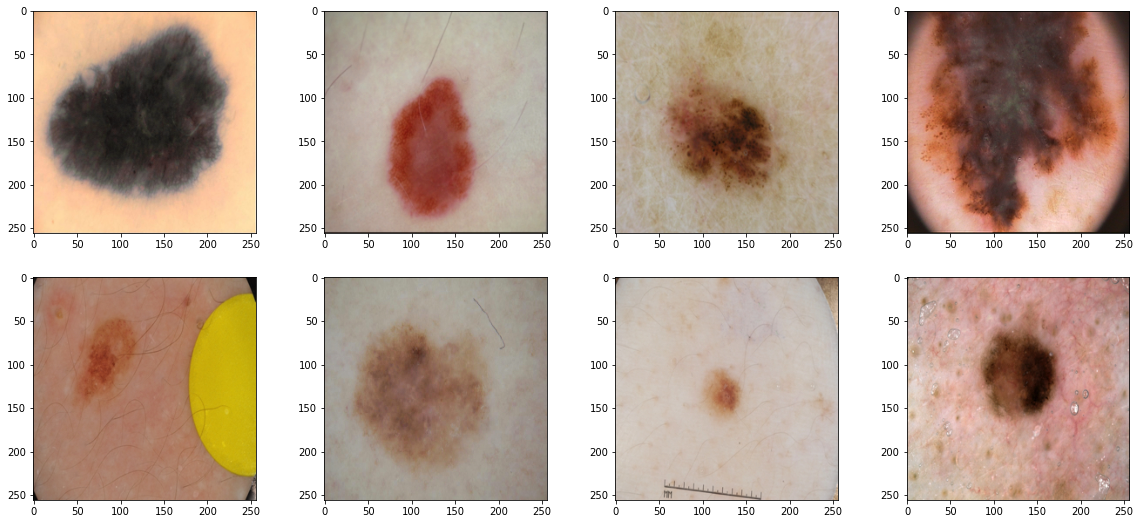

In [4]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(training_images[0], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,2)
plt.imshow(cv2.cvtColor(training_images[55], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,3)
plt.imshow(cv2.cvtColor(training_images[130], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,4)
plt.imshow(cv2.cvtColor(training_images[255], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(training_images[512], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,6)
plt.imshow(cv2.cvtColor(training_images[1024], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,7)
plt.imshow(cv2.cvtColor(training_images[1350], cv2.COLOR_BGR2RGB))
plt.subplot(2,4,8)
plt.imshow(cv2.cvtColor(training_images[1890], cv2.COLOR_BGR2RGB))
plt.show()

Image masks

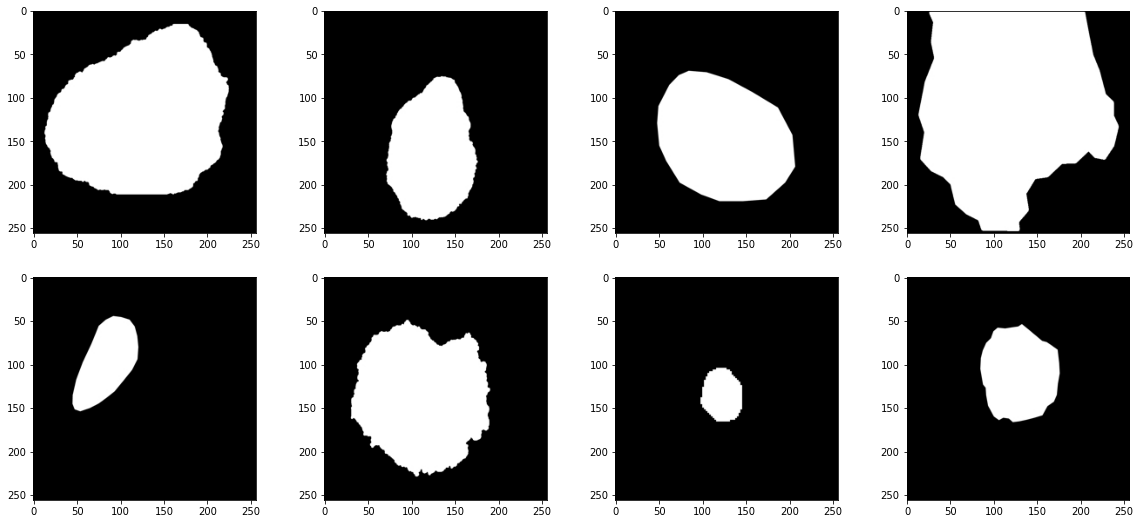

In [5]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(training_groundTruth[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(training_groundTruth[55], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(training_groundTruth[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(training_groundTruth[255], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(training_groundTruth[512], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(training_groundTruth[1024], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(training_groundTruth[1350], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(training_groundTruth[1890], cmap = plt.cm.binary_r)
plt.show()

Unet architecture

In [6]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(filters=3, kernel_size=(1,1), padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model
if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()


2022-01-30 20:51:35.965117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 20:51:36.110763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 20:51:36.111434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 20:51:36.112532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Loss and metrics

In [7]:
from keras import backend as K
from sklearn.metrics import confusion_matrix  

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# def jacc_loss(y_true, y_pred):
#      return 1-iou_score(y_true, y_pred)


def iou_score(y_true, y_pred):
    
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    score = intersection / union

    return np.mean(score)


def compute_iou(y_pred, y_true):
     # ytrue, ypred is a flatten vector
     y_pred = y_pred.flatten()
     y_true = y_true.flatten()
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     # compute mean iou
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU)

Training network

In [8]:
model.compile(loss=[jaccard_distance],
                   optimizer=Adam(learning_rate=1e-5),
                   metrics=[iou])

result = model.fit(training_images,training_groundTruth.astype(np.float32),
                    validation_data=(validation_images, validation_groundTruth.astype(np.float32)),
                    batch_size=24,
                    epochs=50,
                    verbose=1)

2022-01-30 20:51:39.925144: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-01-30 20:51:41.908028: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-01-30 20:51:43.063037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-01-30 20:51:45.882689: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


84/84 [==============================] - 69s 675ms/step - loss: 0.2001 - iou: 0.7999 - val_loss: 0.1789 - val_iou: 0.8211
Epoch 2/50
84/84 [==============================] - 54s 641ms/step - loss: 0.1987 - iou: 0.8013 - val_loss: 0.1789 - val_iou: 0.8211
Epoch 3/50
84/84 [==============================] - 54s 640ms/step - loss: 0.1981 - iou: 0.8019 - val_loss: 0.1781 - val_iou: 0.8219
Epoch 4/50
84/84 [==============================] - 54s 641ms/step - loss: 0.1976 - iou: 0.8024 - val_loss: 0.1772 - val_iou: 0.8228
Epoch 5/50
84/84 [==============================] - 54s 640ms/step - loss: 0.1974 - iou: 0.8026 - val_loss: 0.1767 - val_iou: 0.8233
Epoch 6/50
84/84 [==============================] - 54s 640ms/step - loss: 0.1971 - iou: 0.8029 - val_loss: 0.1766 - val_iou: 0.8234
Epoch 7/50
84/84 [==============================] - 54s 641ms/step - loss: 0.1970 - iou: 0.8030 - val_loss: 0.1763 - val_iou: 0.8237
Epoch 8/50
84/84 [==============================] - 54s 641ms/step - loss: 0.196

stats for 50 epochs

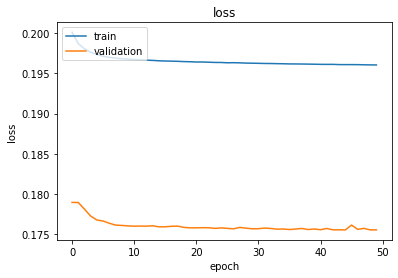

2022-01-30 21:36:48.030261: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.
2022-01-30 21:36:50.066623: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1572864000 exceeds 10% of free system memory.


84/84 [==============================] - 17s 207ms/step - loss: 0.1960 - iou: 0.8040
____________stats on training____________
IOU:       |   80.40  |
Loss:      |   19.60  |
7/7 [==============================] - 1s 183ms/step - loss: 0.1755 - iou: 0.8245
____________stats on validation____________
IOU:       |   82.45  |
Loss:      |   17.55  |
25/25 [==============================] - 6s 209ms/step - loss: 0.2400 - iou: 0.7600
____________stats on test____________
IOU:       |   76.00  |
Loss:      |   24.00  |


In [9]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


res = model.evaluate(training_images, training_groundTruth.astype(np.float32), batch_size= 24)
print('____________stats on training____________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))

res = model.evaluate(validation_images, validation_groundTruth.astype(np.float32), batch_size= 24)
print('____________stats on validation____________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))

res = model.evaluate(test_images, test_groundTruth.astype(np.float32), batch_size= 24)
print('____________stats on test____________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))

Prediction samples

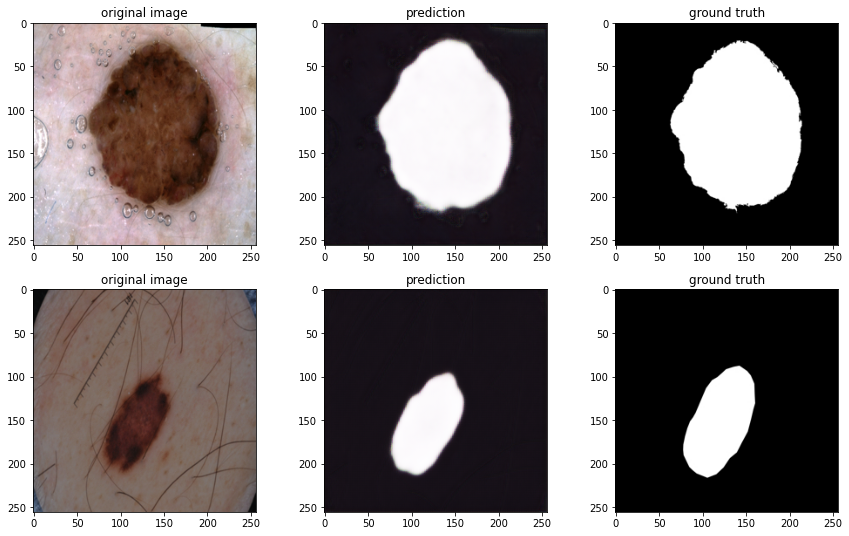

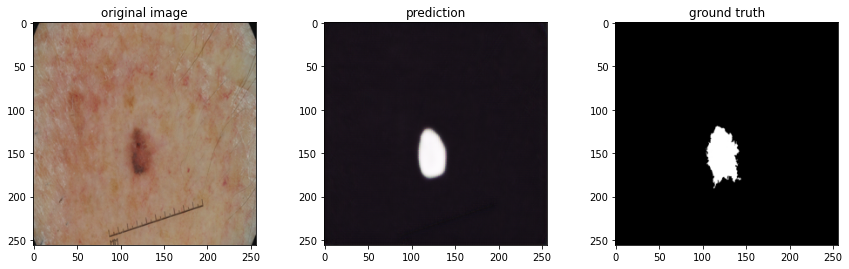

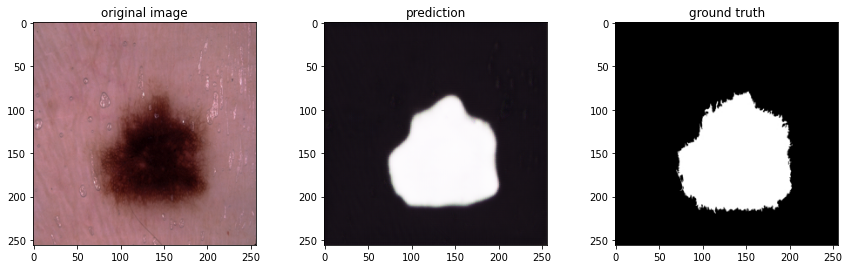

(600, 256, 256, 3)


In [10]:
idx1=470
idx2=1
idx3=170
idx4=244
prediction = np.array(model.predict(test_images))
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(test_images[idx1], cv2.COLOR_BGR2RGB))
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(prediction[idx1], plt.cm.binary_r)
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(cv2.cvtColor(test_groundTruth[idx1], cv2.COLOR_BGR2RGB))
plt.title("ground truth")
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(test_images[idx2], cv2.COLOR_BGR2RGB))
plt.title("original image")
plt.subplot(2,4,6)
plt.imshow(prediction[idx2], plt.cm.binary_r)
plt.title("prediction")
plt.subplot(2,4,7)
plt.imshow(cv2.cvtColor(test_groundTruth[idx2], cv2.COLOR_BGR2RGB))
plt.title("ground truth")
plt.show()
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(test_images[idx3], cv2.COLOR_BGR2RGB))
plt.title("original image")
plt.subplot(2,4,2)
plt.imshow(prediction[idx3], plt.cm.binary_r)
plt.title("prediction")
plt.subplot(2,4,3)
plt.imshow(cv2.cvtColor(test_groundTruth[idx3], cv2.COLOR_BGR2RGB))
plt.title("ground truth")
plt.figure(figsize=(20,9))
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(test_images[idx4], cv2.COLOR_BGR2RGB))
plt.title("original image")
plt.subplot(2,4,6)
plt.imshow(prediction[idx4], plt.cm.binary_r)
plt.title("prediction")
plt.subplot(2,4,7)
plt.imshow(cv2.cvtColor(test_groundTruth[idx4], cv2.COLOR_BGR2RGB))
plt.title("ground truth")
plt.show()
print(np.shape(prediction))

Final enhance

Text(0.5, 1.0, 'ground truth')

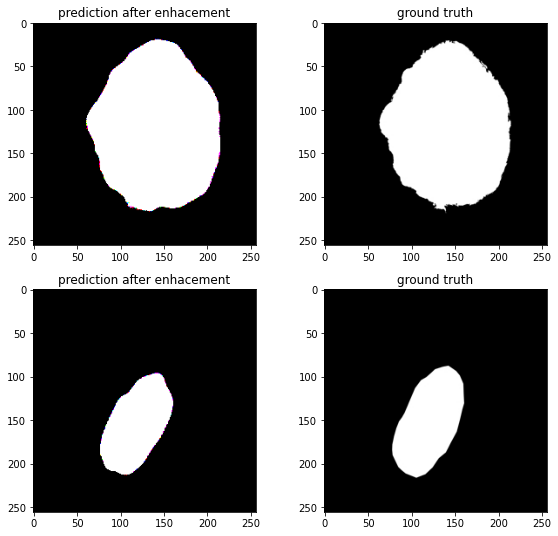

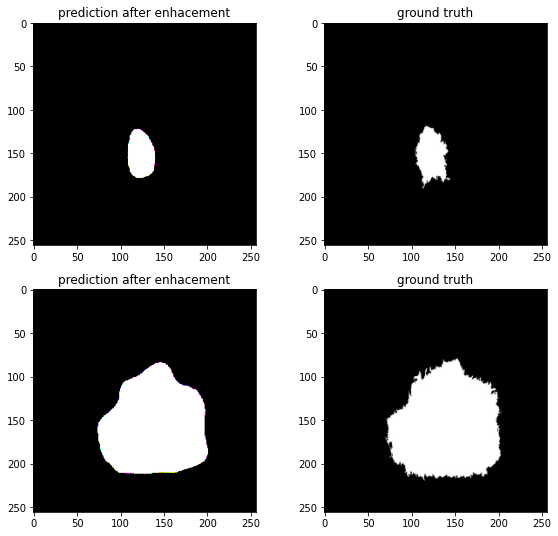

In [11]:
def enhance(img):
    tmp=img.flatten()
    for i in range(len(tmp)):
        if tmp[i]>0.5:
            tmp[i]=1
        else:
            tmp[i]=0
    return tmp.reshape(256,256,3)

plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(enhance(prediction[470]), cv2.COLOR_BGR2RGB))
plt.title('prediction after enhacement')
plt.subplot(2,4,2)
plt.imshow(cv2.cvtColor(test_groundTruth[470], cv2.COLOR_BGR2RGB))
plt.title('ground truth')
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(enhance(prediction[1]), cv2.COLOR_BGR2RGB))
plt.title('prediction after enhacement')
plt.subplot(2,4,6)
plt.imshow(cv2.cvtColor(test_groundTruth[1], cv2.COLOR_BGR2RGB))
plt.title('ground truth')
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(cv2.cvtColor(enhance(prediction[170]), cv2.COLOR_BGR2RGB))
plt.title('prediction after enhacement')
plt.subplot(2,4,2)
plt.imshow(cv2.cvtColor(test_groundTruth[170], cv2.COLOR_BGR2RGB))
plt.title('ground truth')
plt.subplot(2,4,5)
plt.imshow(cv2.cvtColor(enhance(prediction[244]), cv2.COLOR_BGR2RGB))
plt.title('prediction after enhacement')
plt.subplot(2,4,6)
plt.imshow(cv2.cvtColor(test_groundTruth[244], cv2.COLOR_BGR2RGB))
plt.title('ground truth')